<a href="https://colab.research.google.com/github/ParvePalial/FusionAnalysisofLSTMandXgboost/blob/main/Minor_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import important libraries

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

Read the file and conver it to datetime format and sort data by time

In [4]:
df = pd.read_csv("/content/sample_data/delhi_aqi.csv")

# Ensure datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort by time (already sorted)
df = df.sort_values('date').reset_index(drop=True)

We are predicting values of pm2.5 in hourly basis per day.

In [5]:
data = df[['date', 'pm2_5']]

Create Lag Features: Lag features are used to capture temporal dependency by allowing the model to learn how past values influence the current value in a time series<br>
Using 3 lag features means we are modeling the current day’s PM2.5 as dependent on the previous three days’ PM2.5 values. <br>
Here lags = 24 means model is also considering the value 24 hours before. that is... previous day's value

In [6]:
def create_hourly_lags(df, lags=24):
    df = df.copy()
    for lag in range(1, lags + 1):
        df.loc[:, f'lag_{lag}'] = df['pm2_5'].shift(lag)
    return df

data = create_hourly_lags(df, lags=24)
data = data.dropna().reset_index(drop=True)


Input and Output Data

In [7]:
X = data[['lag_1', 'lag_2', 'lag_3']]
y = data['pm2_5']

Split into train and test

In [8]:
split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

XGBoost hyperparameters are empirically tuned using validation performance, starting from standard values and adjusted to balance bias and variance.(boosting)<br>
<br>
***Due to limited data and time constraints, we used heuristic tuning based on known best practices, which is common in academic projects.***

In [9]:
model = XGBRegressor(
    n_estimators=200, # no of boosting rounds -> no of decision trees
    learning_rate=0.05, # shrinkag parameter -> control how much each new tree contribute to overall model.
    max_depth=5, # depth of decision tree
    objective='reg:squarederror', # loss function : Squared error
    random_state=42
)

Train the model

In [10]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

predict output on test data

In [11]:
y_test_pred = model.predict(X_test)

In [12]:
df_test = data.iloc[split_index:].copy()

df_test['actual_pm25'] = y_test.values
df_test['predicted_pm25'] = y_test_pred

df_test['hour'] = pd.to_datetime(df_test['date']).dt.hour

In [13]:
hourly_avg = df_test.groupby('hour')[['actual_pm25', 'predicted_pm25']].mean().reset_index()

Calculate RMSE

In [14]:
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE:", rmse)

RMSE: 56.052863386447854


In [15]:
y_test_pred = model.predict(X_test)

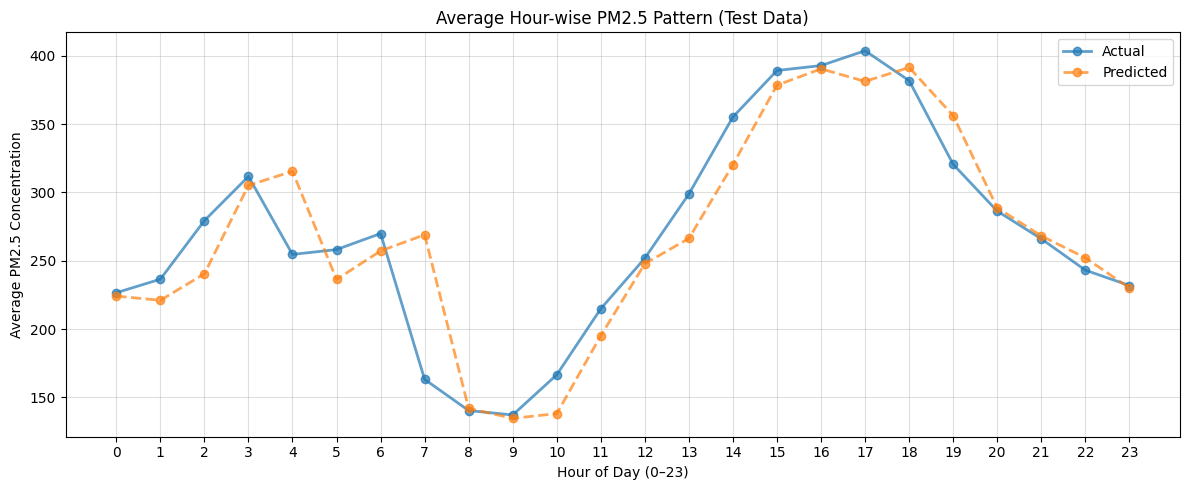

In [16]:
plt.figure(figsize=(12, 5))

plt.plot(
    hourly_avg['hour'],
    hourly_avg['actual_pm25'],
    marker='o',
    linewidth=2,
    alpha=0.7,
    label='Actual'
)

plt.plot(
    hourly_avg['hour'],
    hourly_avg['predicted_pm25'],
    marker='o',
    linewidth=2,
    linestyle='--',
    alpha=0.7,
    label='Predicted'
)

plt.xticks(range(24))
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Average PM2.5 Concentration")
plt.title("Average Hour-wise PM2.5 Pattern (Test Data)")
plt.grid(True, alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()


**From the plot:**<br>


*   Morning rise
*   Midday dip
*   Evening peak
*   Night decline